# 5. Neural Networks

In the previous notebook, we have seen that we can choose feature mappings $\phi$ or kernels $\kappa$
to design powerful non-linear models. Informally, deep learning can be characterised as trying to
learn the feature mapping $\phi$ from data.

In this notebook we will discuss and implement our first

* feed-forward neural network / multi-layer perceptron and
* convolutional neural network

for the MNIST and wine quality classification task.

Keywords: ```Gradient descent```, ```Cross-entropy loss```, ```ReLU```, ```One-hot encoding```, 
```Max pooling```, ```Convolution```, ```keras.layers```, ```model.compile```, ```model.fit```, ```model.evaluate```,  ```model.save```, ```model.summary```, ```models.load_model```, ```keras.optimizers.SGD```

***

## Neural Network Basics

We start with the classical **Feed-Forward Neural Networks (FFNNs)** which are also referred to as multi-layer 
perceptrons (MLPs). FFNNs were originally proposed as a computational model 
simulating mechanisms of the human brain. The general idea is that inputs
are processed in a sequential manner by **artificial neurons**. The common architecture consist of an
input layer, one to several hidden layers, and an output layer as illustrated in the following 
figure. 

<center><img src="images/NN_idea.png" alt="Neural Network Illustration" width="450"/></center>

As before, we try to learn the function $f(X)$. The displayed three-layer FFNN **parameterises** this
function in the following way

\begin{equation}
    f(X,W) =  \sigma \big( \sigma (X W_1 ) W_2 \big) W_3 = \phi (X,W_1,W_2) W_3, 
\end{equation}

where weights $W = (W_1, W_2, W_3)$ are the matrices which we multiply layer-wise to the output of the
previous layer. The outputs are called **activations**. An important part of why neural networks 
are so powerful is the use of **non-linear activation functions**. The 
**rectified linear unit (ReLU)** $\sigma (z) = \max \{0, z \}$ is a particularly popular choice,
e.g. $\sigma (z=-2) = 0$ and $\sigma (z=2) = 2$, with $z$ being the preactivation.

<center><img src="images/ReLU.png" alt="ReLU" width="250"/></center>

We can make a connection between neural networks and what we have seen before. Let's consider
a deeper $L$-layer FFNN. In the regression setting, our goal is again to find a model for

\begin{equation}
    Y = f(X,W) + \epsilon = \phi(X,W_1, \dots, W_{L-1} ) W_L + \epsilon
\end{equation}

where this time $\phi$ is learned! We calibrate our model to solve the task 
by using **(Stochastic) Gradient Descent** for updating the weights $W = (W_1,\dots, W_L)$:

\begin{equation}
    W^{(t+1)} = W^{(t)} - \eta \nabla \text{Loss}(W^{(t)}).
\end{equation}

As illustrated in the figure below, the idea is to start at some position of our loss
landscape described by initially random weights $W^{(t=0)}$ drawn from a Gaussian distribution.
With every update step, we approach a (local) minimum until the weights do not change any longer.
Note that this requires an appropriate choice of the step size or **learning rate** $\eta$ (which
again is a hyperparameter like $\lambda$ and $k$ which we've seen before).

<center><img src="images/Gradient_Descent.png" alt="Gradient Descent" width="350"/></center>

As before, we can use the mean-squared error loss for regression tasks

\begin{equation}
    \text{Loss}(W) = \frac{1}{2N} \lVert Y - f(X,W) \rVert_2^2 = \frac{1}{2N} \sum_{n=1}^{N} \big( y_n -  f(x_n,W) \big)^2.
\end{equation}

In the classification setting, we use the multi-class version of the logistic loss encountered
earlier. In deep learning context, we usually call it the **cross-entropy loss**

\begin{equation}
    \text{Loss}(W) = - \sum_{n=1}^{N} \sum_{c=1}^{C} y_{n,c} \log p_{n,c} = - \sum_{n=1}^{N} \sum_{c=1}^{C} y_{n,c} \log f_c (x_n,W),
\end{equation}

where we consider $C$ different classes our $N$ datapoints belong to. The neural network provides 
in the output layer the probabilities for the different classes $p_{n,c}=f_c (x_n,W)$. For this, we use
another kind of activation function knows as the **softmax activation function** which maps the activation
to the values between 0 and 1. The activation $\sigma(z)_i$
at output neuron $i$ is given by

\begin{equation}
    \sigma(z)_i = \frac{\exp(z_i)}{\sum_{j=1}^{C} \exp (z_j)},
\end{equation}

where $C$ is the number of neurons in the output layer, i.e. the number of classes, and $i,j\in {1,\dots,C}$.
Typically, we change the class labels into a **one-hot encoding** which provides something like a class probability associated with the label. Suppose our datapoint $x_n$ shows the digit 9 and the corresponding
target is $y_n=9$. In the one-hot encoding we replace $y_n$ with the vector

\begin{equation}
    y_{n} = \begin{pmatrix} y_{n,0} \\ y_{n,1} \\ \vdots \\ y_{n,9} \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ \vdots \\ 1 \end{pmatrix},
\end{equation}

where we have 0s at every index but the class index, i.e. 9 in this case.

Let's use all of this in building a FFNN for classifying MNIST digits!

In [5]:
import numpy as np
from tensorflow import keras

mnist_data = np.load('data/mnist_data_5k.npy', allow_pickle=True)
mnist_targets = np.load('data/mnist_labels_5k.npy', allow_pickle=True)

In the following, we normalise the vector of pixel values to 
the $[0,1]$ interval. It is typically advisable to scale all your
predictors in $X$ (i.e. the columns) such that values range between 0 and 1.
Furthermore, we split the data into training, validation, and test datasets.

In [6]:
mnist_data_flat = mnist_data.reshape(-1, 784, 1) / 255

num_train = 3000
num_val = 1000
num_test = 1000

x_train = mnist_data_flat[:num_train]
y_train = mnist_targets[:num_train]

x_val = mnist_data_flat[num_train:num_train+num_val]
y_val = mnist_targets[num_train:num_train+num_val]

x_test = mnist_data_flat[-num_test:]
y_test = mnist_targets[-num_test:]

Now, we define a three-layer FFNN with the following layers sizes:

* 784 neurons in the input layer
* 1024 (hidden) neurons in the first hidden layer with ReLU activation
* 512 (hidden) neurons in the second hidden layer with ReLU activation
* 10 output neurons for our classes in the output layer with a softmax activation

In [7]:
ffnn = keras.Sequential([
    keras.layers.Dense(1024, activation='relu', input_shape=(784,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ], name='FFNN_example')    

2023-03-23 11:39:22.757417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next, we specify hyperparameters. As outlined before, the **learning rate** $\eta$
is an important hyperparameter. In addition, we typically cannot (but also do not want to) 
use all datapoints for training at the same time. We choose small batches of the dataset
and thus need to specify the **batch size**.

In [8]:
learning_rate = 0.01
batch_size = 16
num_epochs = 10

print(f"Shape of training set: {x_train.shape}")
print(f"Number of batches: {x_train.shape[0] / batch_size}")

Shape of training set: (3000, 784, 1)
Number of batches: 187.5


A training **epoch** is concluded after we have seen the total number of batches.
We set multiple epochs to iteratively refine the neural network weights, i.e. training
samples are seen several times during training.

Now, let's define our optimisation method where we use [Stochastic Gradient Descent](https://keras.io/api/optimizers/sgd/).

In [9]:
keras.utils.set_random_seed(123)

ffnn.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

We use as the loss the ```sparse_categorical_crossentropy``` where

* *categorical* means that the neural network outputs are expected to be softmax values between 0 and 1
* *sparse* indicates that we have did not one-hot encode our y-targets; the loss will take care of that

In [10]:
print(y_train)

[5 0 4 ... 9 1 5]


We can now use the methods [fit](https://keras.io/api/models/model_training_apis/#fit-method) and [evaluate](https://keras.io/api/models/model_training_apis/#evaluate-method) to train our FFNN
and evaluate it on the test set.

In [11]:
ffnn_history = ffnn.fit(x=x_train, y=y_train, batch_size=batch_size, 
                        validation_data=(x_val, y_val), epochs=num_epochs)

test_loss, test_acc = ffnn.evaluate(x_test, y_test, verbose=0)

print(f'\nTest accuracy: {test_acc:.4f}')

ffnn.save('output/MNIST_FFNN.h5')

Epoch 1/10
188/188 [==============================] - 3s 13ms/step - loss: 1.5611 - accuracy: 0.6623 - val_loss: 0.9880 - val_accuracy: 0.7920
Epoch 2/10
188/188 [==============================] - 2s 10ms/step - loss: 0.7085 - accuracy: 0.8460 - val_loss: 0.6251 - val_accuracy: 0.8580
Epoch 3/10
188/188 [==============================] - 2s 11ms/step - loss: 0.4892 - accuracy: 0.8800 - val_loss: 0.4892 - val_accuracy: 0.8760
Epoch 4/10
188/188 [==============================] - 2s 11ms/step - loss: 0.3970 - accuracy: 0.8967 - val_loss: 0.4276 - val_accuracy: 0.8870
Epoch 5/10
188/188 [==============================] - 2s 10ms/step - loss: 0.3459 - accuracy: 0.9117 - val_loss: 0.3802 - val_accuracy: 0.9040
Epoch 6/10
188/188 [==============================] - 2s 12ms/step - loss: 0.3083 - accuracy: 0.9187 - val_loss: 0.3617 - val_accuracy: 0.9060
Epoch 7/10
188/188 [==============================] - 3s 14ms/step - loss: 0.2788 - accuracy: 0.9270 - val_loss: 0.3504 - val_accuracy: 0.9070

We can summarise the network parameters:

In [12]:
ffnn.summary()

Model: "FFNN_example"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1,333,770
Trainable params: 1,333,770
Non-trainable params: 0
_________________________________________________________________


Let's see how the accuracy and loss developped over training making
use of the ```ffnn_history``` object we assigned after training.

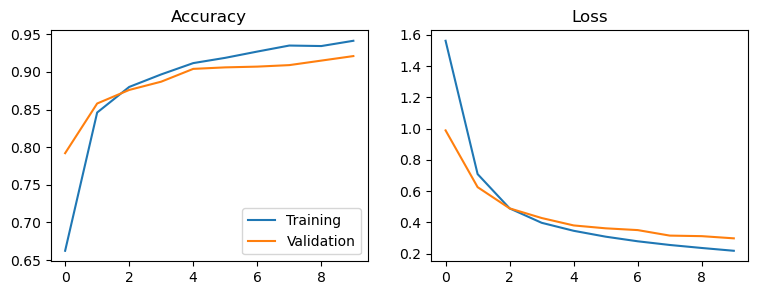

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(9,3))

axs[0].plot(ffnn_history.history['accuracy'], label='Training')
axs[0].plot(ffnn_history.history['val_accuracy'], label='Validation')
axs[0].set_title('Accuracy')
axs[0].legend()

axs[1].plot(ffnn_history.history['loss'])
axs[1].plot(ffnn_history.history['val_loss'])
axs[1].set_title('Loss')

plt.show()

We use the [predict](https://keras.io/api/models/model_training_apis/#predict-method)
method to provide predictions to new data. You can use the model you just trained or you
can load a previously **pretrained** model.

In [18]:
# Our pretrained model (100 epochs):
ffnn = keras.models.load_model('output/MNIST_FFNN_pretrained.h5')

# ... or load the model you trained yourself:
# ffnn = keras.models.load_model('output/MNIST_FFNN.h5')

test_loss, test_acc = ffnn.evaluate(x_test, y_test, verbose=0)

print(f'Test accuracy: {test_acc:.4f}\n')

num_examples = 10

predictions_1hot = ffnn.predict(x_test, verbose=0)

# print(predictions_1hot[0])

nicer_predictions_1hot_0 = list(map(np.format_float_positional, predictions_1hot[0], [5]*10))

print(f"Shape of the predictions: {predictions_1hot.shape}\n")
print(f"First prediction: {nicer_predictions_1hot_0}\n")

predictions = np.argmax(predictions_1hot, axis=1)

print(f"First class prediction: {predictions[0]}")

Test accuracy: 0.9260

Shape of the predictions: (1000, 10)

First prediction: ['0.00000', '0.00000', '0.00004', '0.00043', '0.00000', '0.00000', '0.00000', '0.99954', '0.00000', '0.00000']

First class prediction: 7


Note that the neural network outputs vectors with class probabilities.
We choose the class with the highest probability.

Let's plot some of the predicted labels.

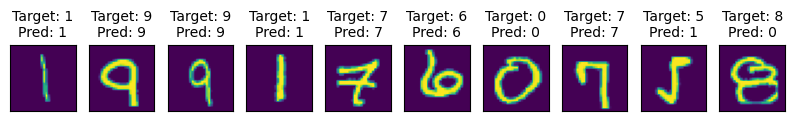

In [19]:
fig, axs = plt.subplots(1,num_examples, figsize=(num_examples,5))

start_index = 900

for i, ax in enumerate(axs.ravel()):
    ax.imshow(x_test[start_index+i].reshape(28,28))    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Target: {y_test[start_index+i]}\nPred: {predictions[start_index+i]}", 
                 fontsize=10)

plt.show()

***

## Convolutional Neural Networks

An important class of neural network architectures are **convolutional neural networks (CNNs)**. CNNs are
inspired by biological models for the primary visual cortex and their resemblance to the mathemtical convolution 
operation. CNNs can be viewed as a particular kind of FFNNs where certain connections are missing and some
neurons share the same weights. This gives rise to architectures as illustrated in the following figure.

<center><img src="images/CNN_example.png" alt="Convolutional Neural Network (LeNet-5)" width="650"/></center>

CNNs are particularly suited to work with images and generally data **where some kind of local
relationship / correlation** are present, e.g. adjacent pixels in an image or adjacent time steps in time series data. Two key components of CNNs are pooling and convolutional layers illustrated in the 
following.

<center><img src="images/Max-pool_Conv.png" alt="Max Pooling and Convolution Operator" width="600"/></center>

**Convolutional layers** use a **convolutional filter** (sometimes called *kernel*, too) which processes the input images with respect to particular features (like edges) producing **feature maps**. Sequentially applying convolutional layers allow for **identifying increasingly complex features**. A typical size of a convolutional filter is $3 \times 3$ which can be thought of as a matrix of weights (in red above) which are adjusted during training to identify features in a data-driven fashion.

**Pooling layers** reduce the resolution of feature maps and don't have any associated weights. In particular, 
max pooling layers of size $2 \times 2$ are used to identify the main activation in adjecent pixels.
This allows objects to be in different positions in the image but still be recognised as the same object.

Let's implement such a CNN and reshape the image vectors to actual images again.

In [20]:
mnist_data_image = mnist_data.reshape(-1, 28, 28, 1) / 255

x_train = mnist_data_image[:num_train]
x_val = mnist_data_image[num_train:num_train+num_val]
x_test = mnist_data_image[-num_test:]

We define a CNN with the following layers and train as before:

* 28 $ \times $ 28 $ \times $ 1 neurons in the input layer for the greyscale image
* 6 conv. filters of size $3 \times 3$ in the first hidden layer with ReLU activation followed by a $2 \times 2$ max pooling
* 16 conv. filters of size $3 \times 3$ in the first hidden layer with ReLU activation followed by a $2 \times 2$ max pooling
* flatten these feature maps in a single vector 
* 1024 (hidden) neurons in the second hidden layer with ReLU activation
* 512 (hidden) neurons in the second hidden layer with ReLU activation
* 10 output neurons for our classes in the output layer with a softmax activation

In [21]:
keras.utils.set_random_seed(123)

cnn = keras.Sequential([
    keras.layers.Conv2D(6, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ], name='CNN_example') 

cnn.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_history = cnn.fit(x=x_train, y=y_train, batch_size=batch_size, 
                      validation_data=(x_val, y_val), epochs=num_epochs)

test_loss, test_acc = cnn.evaluate(x_test, y_test, verbose=0)

print(f'\nTest accuracy: {test_acc:.4f}\n')

cnn.save('output/MNIST_CNN.h5')

cnn.summary()

Epoch 1/10
188/188 [==============================] - 5s 21ms/step - loss: 2.0534 - accuracy: 0.4463 - val_loss: 1.3186 - val_accuracy: 0.6720
Epoch 2/10
188/188 [==============================] - 4s 21ms/step - loss: 0.7040 - accuracy: 0.8110 - val_loss: 0.6086 - val_accuracy: 0.8120
Epoch 3/10
188/188 [==============================] - 4s 20ms/step - loss: 0.4119 - accuracy: 0.8743 - val_loss: 0.3993 - val_accuracy: 0.8700
Epoch 4/10
188/188 [==============================] - 4s 23ms/step - loss: 0.3018 - accuracy: 0.9123 - val_loss: 0.3021 - val_accuracy: 0.8970
Epoch 5/10
188/188 [==============================] - 5s 25ms/step - loss: 0.2515 - accuracy: 0.9263 - val_loss: 0.2094 - val_accuracy: 0.9430
Epoch 6/10
188/188 [==============================] - 4s 19ms/step - loss: 0.2127 - accuracy: 0.9390 - val_loss: 0.2174 - val_accuracy: 0.9360
Epoch 7/10
188/188 [==============================] - 4s 23ms/step - loss: 0.1811 - accuracy: 0.9457 - val_loss: 0.2416 - val_accuracy: 0.9270

Let's study the performance of the CNN.

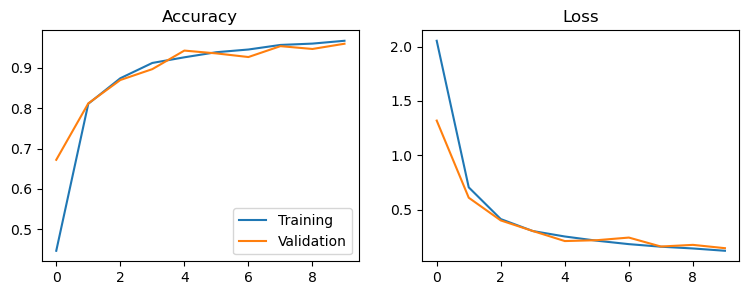

Test accuracy: 0.9310



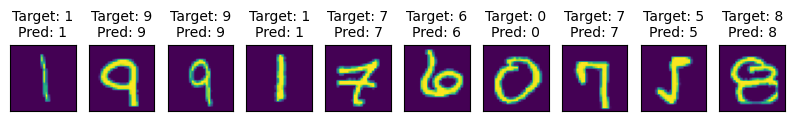

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(9,3))

axs[0].plot(cnn_history.history['accuracy'], label='Training')
axs[0].plot(cnn_history.history['val_accuracy'], label='Validation')
axs[0].set_title('Accuracy')
axs[0].legend()

axs[1].plot(cnn_history.history['loss'])
axs[1].plot(cnn_history.history['val_loss'])
axs[1].set_title('Loss')

plt.show()

# Our pretrained model (100 epochs):
# cnn = keras.models.load_model('output/MNIST_CNN_pretrained.h5')

# ... or load your model:
cnn = keras.models.load_model('output/MNIST_CNN.h5')

test_loss, test_acc = cnn.evaluate(x_test, y_test, verbose=0)

print(f'Test accuracy: {test_acc:.4f}\n')

num_examples = 10

predictions_1hot = cnn.predict(x_test, verbose=0)
predictions = np.argmax(predictions_1hot, axis=1)

fig, axs = plt.subplots(1, num_examples, figsize=(num_examples,5))

start_index = 900

for i, ax in enumerate(axs.ravel()):
    ax.imshow(x_test[start_index+i])    
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Target: {y_test[start_index+i]}\nPred: {predictions[start_index+i]}", 
                 fontsize=10)

plt.show()

***

## Exercise Section

For a final time, we consider the red wine dataset with our new regression method.
As before, we want to predict the ```quality``` values on the test set ```feat_test``` 
and compare it to the previous results:

* ridge regression MSE 0.42 
* Random Forest regression MSE 0.34
* kernel ridge regression MSE 0.38 
* Gaussian Process regression MSE 0.38

Prepare the data by load the following cell:

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras

np.random.seed(123)
keras.utils.set_random_seed(123)

wine_data = pd.read_csv('data/winequality-red.csv', sep=';')

ex_target = wine_data['quality']
ex_features = wine_data.drop(['quality'], axis=1)

ex_features = (ex_features - ex_features.min()) / (ex_features.max() - ex_features.min())  

feat_train, feat_test, target_train, target_test = train_test_split(
    ex_features, ex_target, test_size = 0.3, random_state=123)

target_test = target_test.to_frame()

(1.) Implement a feed-forward neural network with the following number 
of artificial neurons in the hidden layers: 1024, 512, 256, 128, 64. Use
ReLU activations and the following hyperparameters:

In [ ]:
learning_rate = 0.005
batch_size = 64
num_epochs = 50

Put your result in the following cell and note:

* Provide the model as ```ffnn_reg```, the history of the training in ```ffnn_reg_history```, and the predicted quality values in ```ex_pred_ffnn```. 
* The output in the regression setting is just 1-dimensional and no activation is required. 
* Use as the MSE loss ```keras.losses.MeanSquaredError()``` and do not use the ```metrics``` argument.
* You can use the test set for ```validation_data```. 

In [ ]:
# fill in

Try to check the accuracy and loss during training with the following plot.

In [ ]:
plt.plot(ffnn_reg_history.history['loss'][1:], label='Training')
plt.plot(ffnn_reg_history.history['val_loss'][1:], label='Test')
plt.title('Loss')
plt.legend()

plt.show()

As we have done earlier, the following cell provides a 
data frame with an overview of the predictions.

In [ ]:
target_test['NN_predicted_quality'] = np.around(ex_pred_ffnn, decimals=2)
target_test['NN_absolut_deviation'] = np.around(abs(target_test['quality'] - target_test['NN_predicted_quality']), decimals=2)
print(target_test)

NN_pred_MSE = (target_test['NN_absolut_deviation']**2).mean()
print(f"\nMean squared error of Feedforward Neural Network regression: {NN_pred_MSE:.2f}")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras

np.random.seed(123)
keras.utils.set_random_seed(123)

wine_data = pd.read_csv('data/winequality-red.csv', sep=';')

ex_target = wine_data['quality']
ex_features = wine_data.drop(['quality'], axis=1)

ex_features = (ex_features - ex_features.min()) / (ex_features.max() - ex_features.min())  

feat_train, feat_test, target_train, target_test = train_test_split(
    ex_features, ex_target, test_size = 0.3, random_state=123)

target_test = target_test.to_frame()

2023-03-21 12:53:11.016835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(1.) Implement a feed-forward neural network with the following number 
of artificial neurons in the hidden layers: 1024, 512, 256, 128, 64. Use
ReLU activations and the following hyperparameters:

In [2]:
learning_rate = 0.005
batch_size = 64
num_epochs = 50

Put your result in the following cell and note:

* Provide the model as ```ffnn_reg```, the history of the training in ```ffnn_reg_history```, and the predicted quality values in ```ex_pred_ffnn```. 
* The output in the regression setting is just 1-dimensional and no activation is required. 
* Use as the MSE loss ```keras.losses.MeanSquaredError()``` and do not use the ```metrics``` argument.
* You can use the test set for ```validation_data```. 

In [3]:
ffnn_reg = keras.Sequential(
    [
    keras.layers.Dense(1024, activation='relu', input_shape=(11,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
    ],
    name='FFNN_regression')    

ffnn_reg.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
                 loss=keras.losses.MeanSquaredError())

ffnn_reg_history = ffnn_reg.fit(x=feat_train, y=target_train, 
                                validation_data=(feat_test, target_test), 
                                batch_size=batch_size, epochs=num_epochs)

ex_pred_ffnn = ffnn_reg.predict(feat_test, verbose=0)

ffnn_reg.save(f'output/MNIST_FFNN_reg.h5')

Epoch 1/50


2023-03-21 12:53:13.838010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


18/18 [==============================] - 1s 15ms/step - loss: 17.3084 - val_loss: 0.6507
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6783 - val_loss: 0.6384
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6341 - val_loss: 0.5898
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 0.6149 - val_loss: 0.5527
Epoch 5/50
18/18 [==============================] - 0s 9ms/step - loss: 0.5946 - val_loss: 0.6049
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.5648 - val_loss: 0.5109
Epoch 7/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5551 - val_loss: 0.5547
Epoch 8/50
18/18 [==============================] - 0s 9ms/step - loss: 0.5414 - val_loss: 0.4864
Epoch 9/50
18/18 [==============================] - 0s 7ms/step - loss: 0.5218 - val_loss: 0.4878
Epoch 10/50
18/18 [==============================] - 0s 8ms/step - loss: 0.4996 - val_loss: 0.4796
Epoch 11/50
18/18 [=========

Try to check the accuracy and loss during training with the following plot.

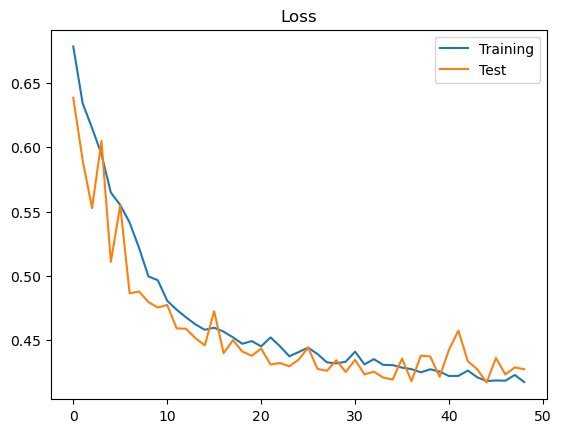

In [4]:
plt.plot(ffnn_reg_history.history['loss'][1:], label='Training')
plt.plot(ffnn_reg_history.history['val_loss'][1:], label='Test')
plt.title('Loss')
plt.legend()

plt.show()

As we have done earlier, the following cell provides a 
data frame with an overview of the predictions.

In [5]:
# Pretrained for 1000 epochs
#ffnn_reg = keras.models.load_model('output/MNIST_FFNN_reg_pretrained.h5')
#ex_pred_ffnn = ffnn_reg.predict(feat_test, verbose=0)

In [6]:
target_test['NN_predicted_quality'] = np.around(ex_pred_ffnn, decimals=2)
target_test['NN_absolut_deviation'] = np.around(abs(target_test['quality'] - target_test['NN_predicted_quality']), decimals=2)
print(target_test)

NN_pred_MSE = (target_test['NN_absolut_deviation']**2).mean()
print(f"\nMean squared error of Feedforward Neural Network regression: {NN_pred_MSE:.2f}")

      quality  NN_predicted_quality  NN_absolut_deviation
912         6                  6.52                  0.52
772         5                  5.09                  0.09
1037        5                  4.91                  0.09
1106        6                  6.60                  0.60
263         5                  5.51                  0.51
...       ...                   ...                   ...
1466        7                  5.61                  1.39
580         5                  5.44                  0.44
1082        6                  5.47                  0.53
1279        7                  6.35                  0.65
1155        5                  5.34                  0.34

[480 rows x 3 columns]

Mean squared error of Feedforward Neural Network regression: 0.43
